In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

jtplot.style()

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("./input/train.csv")
survived = dataset[dataset['Survived'] == 1]
passing = dataset[dataset['Survived'] == 0]

Percentage of Class 1 that survived: 63.0 %
Percentage of Class 2 that survived: 47.0 %
Percentage of Class 3 that survived: 24.0 %


,1,2,3
Survived,136,87,119
Died,80,97,372


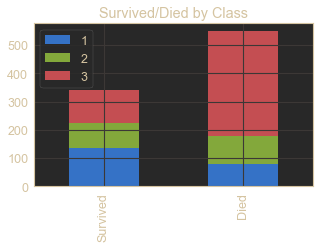

In [3]:
%matplotlib inline

#-------------------Survived/Died by Class -------------------------------------
survived_class = survived['Pclass'].value_counts()
dead_class = passing['Pclass'].value_counts()
df_class = pd.DataFrame([survived_class,dead_class])
df_class.index = ['Survived','Died']
df_class.plot(kind='bar',stacked=True, figsize=(5,3), title="Survived/Died by Class")

Class1_survived= df_class.iloc[0,0]/df_class.iloc[:,0].sum()*100
Class2_survived = df_class.iloc[0,1]/df_class.iloc[:,1].sum()*100
Class3_survived = df_class.iloc[0,2]/df_class.iloc[:,2].sum()*100
print("Percentage of Class 1 that survived:" ,round(Class1_survived),"%")
print("Percentage of Class 2 that survived:" ,round(Class2_survived), "%")
print("Percentage of Class 3 that survived:" ,round(Class3_survived), "%")

# display table
from IPython.display import display
display(df_class)

Male:  19.0 %
Female:  74.0 %


,female,male
Survived,233,109
Passed,81,468


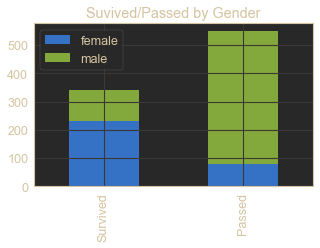

In [4]:
survived_gender = survived['Sex'].value_counts()
passing_gender = passing['Sex'].value_counts()

df_gender = pd.DataFrame([survived_gender, passing_gender])
df_gender.index = ['Survived', 'Passed']
df_gender.plot(kind='bar', stacked=True, figsize=(5,3), title="Suvived/Passed by Gender")

male_survival = df_gender.iloc[0, 1] / df_gender.iloc[:, 1].sum() * 100
female_survival = df_gender.iloc[0, 0] / df_gender.iloc[:, 0].sum() * 100

print("Male: ", round(male_survival), "%")
print("Female: ", round(female_survival), "%")

display(df_gender)